In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns

print("Libraries imported successfully ✅")


Libraries imported successfully ✅


In [2]:
df = pd.read_csv("uber.csv")   # <-- rename file if needed
print("Dataset loaded.")
df.head()


Dataset loaded.


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
print("Missing values BEFORE cleanup:\n", df.isna().sum())

# dropping missing rows — dataset is large enough to allow this
df.dropna(inplace=True)

print("\nMissing values AFTER cleanup:\n", df.isna().sum())


Missing values BEFORE cleanup:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

Missing values AFTER cleanup:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [4]:
# convert datetime string → datetime object
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

# extract hour of the day (0–23)
df["time"] = df["pickup_datetime"].dt.hour

# remove original column since it's no longer useful
df.drop(["pickup_datetime"], axis=1, inplace=True)
df.drop(["key"], axis=1, inplace=True)


df.head()

"""
Example:
    '2013-01-03 22:17:48 UTC'  -->  time = 22
We extract only the hour because surge pricing depends on time!
"""


"\nExample:\n    '2013-01-03 22:17:48 UTC'  -->  time = 22\nWe extract only the hour because surge pricing depends on time!\n"

In [5]:
df.head()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time
0,24238194,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19
1,27835199,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20
2,44984355,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21
3,25894730,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8
4,17610152,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17


In [6]:
def calculate_distance(lat1, lon1, lat2, lon2):
    # simple euclidean approximation works for NYC dataset
    return math.sqrt((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2)

df["distance"] = df.apply(
    lambda row: calculate_distance(
        row["pickup_latitude"], row["pickup_longitude"],
        row["dropoff_latitude"], row["dropoff_longitude"]
    ),
    axis=1
)

df.head()


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time,distance
0,24238194,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,0.015140
1,27835199,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,0.022103
2,44984355,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,0.053109
3,25894730,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,0.016528
4,17610152,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,0.051031


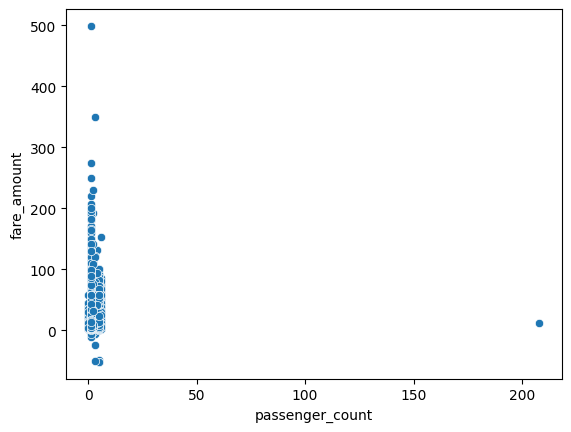

In [7]:
# remove outlier(s) where passenger_count > 100
sns.scatterplot(df, y="fare_amount", x="passenger_count")
df = df[df["passenger_count"] < 150]

In [8]:
# remove outliers from pickup/dropoff locations
def remove_outliers(feature):
    global df
    q3 , q1 = np.percentile( df[feature] , [ 75 , 25 ] )
    iqr = q3 - q1
    df = df[ (df[feature] >= q1 - 1.5 * iqr) & (df[feature] <= q3 + 1.5 * iqr) ]

for feature in ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "fare_amount"]:
    remove_outliers(feature)

print("Outliers removed.")


Outliers removed.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop("fare_amount", axis=1)
y = df["fare_amount"]

# train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split + scaling done.")


Data split + scaling done.


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)

pred_lr = lin_model.predict(X_test_scaled)

print("Linear Regression Results:")
print("R² Score:", r2_score(y_test, pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))


Linear Regression Results:
R² Score: 0.6463496522254231
RMSE: 2.0945549200789726


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

rf_model = RandomForestRegressor()
rf_model.fit(X_train_scaled, y_train)

pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Regression Results:")
print("R² Score:", r2_score(y_test, pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))


Random Forest Regression Results:
R² Score: 0.7071734526590325
RMSE: 1.905943099222044
